# Node Setup

The node which implements the interface is called `jupyter_ui`. 

## Libraries

Here are the needed libraries for the functioning of this Jupyter interface:

In [1]:
# jupyter
import ipywidgets as widgets
import jupyros

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.transforms as mtransforms
from matplotlib.animation import FuncAnimation

# numpy
import numpy as np

# ROS libraries
import rospy
from std_srvs.srv import SetBool, SetBoolRequest, SetBoolResponse
from geometry_msgs.msg import Twist, Pose, Vector3
from nav_msgs.msg import Odometry
from tf.transformations import euler_from_quaternion, quaternion_from_euler

# other python specific
import math

## Node Init

In [2]:
# init
rospy.init_node( "jupyter_ui" )
rospy.on_shutdown( lambda : rospy.loginfo( "jupyter_ui down..." ) )

## Topics and Services

### Behaviour Switch

This service allows the user interface to switch between the so-called "random behaviour" and the manual mode. 

In [3]:
# rospy.wait_for_service( "/ui_trigger" )
ui_mode = rospy.ServiceProxy( "/ui_trigger", SetBool )

By default, the manual mode is set. 

In [4]:
# set by the function
manual_mode = True

# default: manual mode (call the service with True to enable the manual mode)
ui_mode( manual_mode )

success: False
message: ''

In order to make easier the management of the behaviour, a function is provided for switching between the behaviours.

In [5]:
def switch_robot_behaviour( ):
    '''Switch between manual and authomatic behaviour.
    
    Returns
    -------
    Bool
        the new state: if the manual mode has been set or not. 
    '''
    
    global ui_mode, manual_mode
    
    # switch the status
    manual_mode = not manual_mode
    
    # send the new status
    ui_mode( manual_mode )
    
    return manual_mode

### Topic */cmd_vel* 

The Jupyter interface can directly interact with the simulation through the topic `/cmd_vel`. 

First of all, the last command is globally available as the variable `tw`. 

In [6]:
# the last command
tw  = Twist( )

# publisher to /cmd_vel
cmd_vel = rospy.Publisher( "/cmd_vel", Twist, queue_size=1000 )

Publishing on this topic is allowed **only** when the robot is ins manual behaviour. Here is a function to enforce this costraint:

In [7]:
def pub_cmd_vel( stw = Twist( ) ):
    '''publish on /cmd_vel depending on manual_mode
    
    Parameters
    ----------
    stw : geometry_msgs/msg/Twist, optional
        the twist to send through the topic. Default is the zero twist. 
    
    Returns
    -------
    bool
        if the new twist has been sent or not. 
    '''
    
    global cmd_vel, manual_mode
    
    # send only if the manual mode is set
    if manual_mode:
        cmd_vel.publish( stw )
    
    # let's assume that the publisher is always reliable
    return manual_mode

### Subscriber to */odom*

The callback simply takes the message and saves it into a global variable of the program.

In [8]:
# the last received odometry (init as empty message)
last_odom_msg = Odometry( )

# other function can be added inside the odometry (with no args)
call_after_save_odom = list( )

# the callback
def save_odometry( msg ):
    '''save the received odometry'''
    
    global last_odom_msg, call_after_save_odom
    last_odom_msg = msg
    
    # execute other callbacks if any
    if len( call_after_save_odom ) > 0 :
        for fnc in call_after_save_odom:
            fnc.__call__( )

# subscription to /odom
rospy.Subscriber( "/odom", Odometry, save_odometry )

# Controlling the robot

Here are the widgets created for controlling the robot in a more intuitive fashon for the user.

## Switching between modes -- basic version

Here a switch allows the user to choose between the behaviours using a ToggleButton:

- when shaded, the authomatic mode is on
- when light, the robot is waiting for a command from Jupyter.

Here is the callback called each time the user interacts with the widget:

In [9]:
def change_ui_status( val ):
    '''callback for changing the status compatible with the ToggleButton widget. '''
    
    switch_robot_behaviour( )

Here is the widget. Note that, by default, the widget is unshaded, hence the manual command is set. 

In [10]:
togglebutton_ui_trigger = widgets.ToggleButton( 
    description = "Random Behaviour",
    value = False )

togglebutton_ui_trigger.observe( change_ui_status, names='value' )
display( togglebutton_ui_trigger )

ToggleButton(value=False, description='Random Behaviour')

**Note well**: this widget doesn't take into account the status of the other widgetsbeing used for controlling the robot. In order to keep the interface consistent, it is convenient to disabile the widgets for manually setting a velocity while the random behaviour is on. 

## Sliders

Sliders let the user to directly control the two main velocities of the robot: 

- the linear velocity along the direction in front of the robot
- the angular velocity about the z axis

The sliders are "observed", meaning that each time the user moves one slider, the global twist is observed and sent to the robot. Here are the two functions:

In [11]:
def on_linear_change( slider_v ):
    '''update and send the linear velocity along x'''
    
    global tw
    
    tw.linear.x = slider_v['new']
    pub_cmd_vel( tw )

def on_angular_change( slider_a ):
    '''update and send the angular velocity about z'''
    
    global tw
    
    tw.angular.z = slider_a['new']
    pub_cmd_vel( tw )
    
def slider_set_zero( bclick ):
    '''set zero to both the sliders and stop the robot'''
    
    global slider_linear, slider_angular, tw
    
    slider_linear.value  = 0.0
    slider_angular.value = 0.0
    
    # set zero velocity
    tw = Twist( )
    
    pub_cmd_vel( tw )
    

Here are the sliders:

In [12]:
# for the linear component
slider_linear  = widgets.FloatSlider( min=-1.0, max=1.0, value=0, step=0.1, readout=True )

# for the angular velocity
slider_angular = widgets.FloatSlider( min=-np.pi, max=np.pi, value=0, step=0.1, readout=True )

# useful to stop the robot
button_set_zero = widgets.Button( value=False, description="set zero" )

# observe the values of the sliders
slider_linear.observe( on_linear_change, names="value" )
slider_angular.observe( on_angular_change, names="value" )
button_set_zero.on_click( slider_set_zero )

display( slider_linear, slider_angular, button_set_zero )

FloatSlider(value=0.0, max=1.0, min=-1.0)

FloatSlider(value=0.0, max=3.141592653589793, min=-3.141592653589793)

Button(description='set zero', style=ButtonStyle())

**Note well**: they should be disabled while the manual mode is not set. Moreover, the stop button shoud be synchronized with the other widgets of this interface. 

## Control Pad

Here is the CSS used to set the graphical aspect of the pad. Flex is applied here:

In [13]:
lay_item = widgets.Layout( 
    display="auto" )

lay_vitem = widgets.Layout( 
    display="auto", 
    align_self="center" )

lay_stop_button = widgets.Layout( 
    display="auto", 
    align_self="center", 
    width="75%", 
    margin="0" )

lay_auto_vcenter = widgets.Layout( 
    display="auto",
    position="absolute",
    top="50%" )

lay_vertical = widgets.Layout(
    display="flex", 
    flex_flow="column",
    align_items="stretch",
    justify_content="center" )

lay_horizontal = widgets.Layout(
    display="flex",
    flex_direction="column",
    justify_content="center",
    align_items="baseline" )

The pad requires some function to work:

In [14]:
# labels showing the velocities, over the pad
txt_front = widgets.Label( value="front: 0.00m/s", layout=lay_vitem )
txt_left = widgets.Label( value="left: 0.00m/s", layout=lay_vitem )
txt_rot = widgets.Label( value="rotation: 0.00rad/s", layout=lay_vitem )

def update_vel_txt( ):
    '''update the label widgets whowing the velocity'''
    
    global last_odom_msg, txt_front, txt_left, txt_rot
    
    msg = last_odom_msg
    txt_front.value = ("front: {:.2f}m/s").format( msg.twist.twist.linear.x )
    txt_left.value = ("left: {:.2f}m/s").format( msg.twist.twist.linear.y )
    txt_rot.value = ("rotation: {:.2f}rad/s").format( msg.twist.twist.angular.z )
    
# add the function to the list of callbacks to execute after the main one
call_after_save_odom.append( update_vel_txt )

# used to update the velocity
linear_step = 0.5
angular_step = 0.25

# common part of the functions below
def update_vel( ):
    global tw
    pub_cmd_vel( tw )

# pad keys callbacks
def stop_all( b ):
    global tw
    tw = Twist( )
    update_vel( )

def up( b ):
    global tw, linear_step
    tw.linear.x = tw.linear.x + linear_step
    update_vel( )

def down( b ):
    global tw, linear_step
    tw.linear.x = tw.linear.x - linear_step
    update_vel( )

def left( b ):
    global tw, angular_step
    tw.angular.z = tw.angular.z - angular_step
    update_vel( )

def right( b ):
    global tw, angular_step
    tw.angular.z = tw.angular.z + angular_step
    update_vel( )

And here is the pad for anually controlling the robot. 

In [15]:
# keys of the pad
b_up = widgets.Button( description="^", layout=lay_item )
b_down = widgets.Button( description="v", layout=lay_item )
b_left = widgets.Button( description="<", layout=lay_vitem )
b_right = widgets.Button( description=">", layout=lay_vitem )
b_stop = widgets.Button( description="STOP", layout=lay_stop_button)

# layout organization --- text
txt_box = widgets.Box( [txt_front, txt_left, txt_rot], layout=lay_horizontal )

# layout organization --- pad
vertical_buttons = widgets.Box( [b_up, b_down], layout=lay_vertical )
cmd_pad = widgets.Box( [b_left, vertical_buttons, b_right], layout=lay_horizontal )
complete_pad = widgets.Box( [txt_box, cmd_pad, b_stop], layout=lay_vertical )

# callbacks
b_up.on_click( up )
b_down.on_click( down )
b_left.on_click( left )
b_right.on_click( right )
b_stop.on_click( stop_all )

display( complete_pad )

Box(children=(Box(children=(Label(value='front: -0.00m/s', layout=Layout(align_self='center', display='auto'))…

# Visualization

In [16]:
%matplotlib notebook

## Position and orientation of the robot across the map

An arrow shows the orientation of the robot. The representation is built as animation in MatPlotLib. 

Label(value='---')

<IPython.core.display.Javascript object>


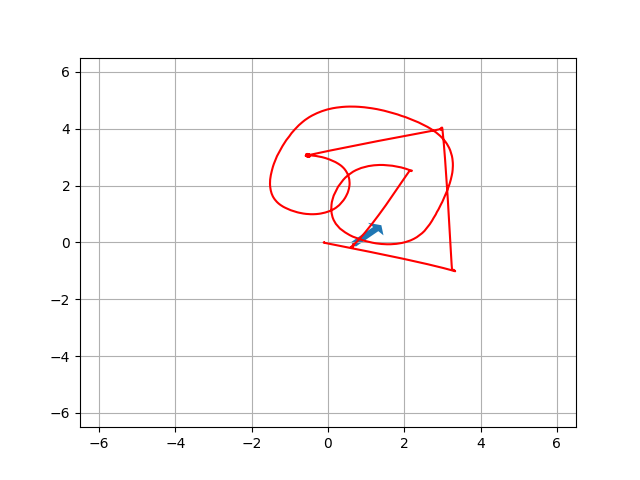

In [17]:
wtext = widgets.Label( value="---" )
display( wtext )
fig, ax = plt.subplots( )

x = []
y = []

area = 6.5
trajectory, = ax.plot( x, y, '-r' )
arrow_pos = patch.Arrow( 0, 0, 1, 0 )
ax.set_xlim( -area, area )
ax.set_ylim( -area, area )
ax.grid( True )

def update_position( frame ):
    '''read the last odometry and update the data inside the plot'''
    
    global x, y, trajectory, last_odom_msg, ax, arrow_pos, wtext
    
    tw = last_odom_msg.twist.twist
    pos = last_odom_msg.pose.pose.position
    qrot = last_odom_msg.pose.pose.orientation
    rot = euler_from_quaternion( [ qrot.x, qrot.y, qrot.z, qrot.w ] )[2]
    
    x.append( pos.x )
    y.append( pos.y )
    trajectory.set_data( x, y )
    
    trot = mtransforms.Affine2D.from_values( np.cos( rot ), np.sin( rot ), -np.sin( rot ), np.cos( rot ), pos.x, pos.y )
    arrow_pos._patch_transform = trot.frozen( )
    
    wtext.value = f"pos({pos.x:.2f}m, {pos.y:.2f}m) th({rot:.2f}rad) -- twist({tw.linear.x:.2f}m/s, {tw.linear.y:.2f}m/s, {tw.angular.z:.2f}rad/s)"
    
    return (trajectory, arrow_pos)

def init_animation( ):
    '''init the plot, showing the first position and orientation'''
    
    global x, y, trajectory, ax, arrow_pos
    
    pos = last_odom_msg.pose.pose.position
    qrot = last_odom_msg.pose.pose.orientation
    rot = euler_from_quaternion( [ qrot.x, qrot.y, qrot.z, qrot.w ] )[2]
    
    x.append( pos.x )
    y.append( pos.y )
    trajectory.set_data( x, y )
    
    trot = mtransforms.Affine2D.from_values( np.cos( rot ), np.sin( rot ), -np.sin( rot ), np.cos( rot ), pos.x, pos.y )
    arrow_pos._patch_transform = trot.frozen( )
    ax.add_patch( arrow_pos )
    
    return (trajectory, arrow_pos)

anim = mpl.animation.FuncAnimation( 
    fig, update_position, interval=125, blit=True, save_count = True, init_func=init_animation )

# Improvements

Il codice grossomodo è quello riportato qui. Per produrre l'interfaccia finale però serve fare ancora qualche correzione: 

- il documento dovrebbe essere diviso in: setup, definizione dei widget e dello stile, definizione delle callbacks, e solo alla fine display dei widgets. In questo modo puoi controllare eventuali eventi incrociati, perchè tutto risulta definitio. 
- lo switch tra i due stati puoi controllarlo con una funzione generica che mette a posto tutti i widgets da sola
- anche i vari diplay li puoi organizzare in funzioni, in modo da poter richiamare i widget in da qualunque parte del codice senza copiare incollare ogni volta tutto.